In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Dict, List

### Helper Code

In [2]:
class State:
    def __init__(self, color: str) -> None:
        self.color = color

    def transition(self):
        pass


class Recovered(State):
    def __init__(self, color: str = 'green') -> None:
        super().__init__(color)

    def transition(self) -> State:
        return self
    

class Infectious(State):
    def __init__(self, color: str = 'red', masks: bool = False) -> None:
        super().__init__(color)
        self.n_days_to_recovered = int(np.ceil(np.random.lognormal(2.25, 0.105, 1)[0]))
        self.n_days_infectious = 0
        self.masks = masks

    def prob_infection(self) -> float:
        p_1c = 0.12 * 0.35 if self.masks else 0.12
        beta = -0.00504

        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (self.n_days_infectious ** 3 - 1))
        denominator = 1 + numerator
        prob_infection = numerator / denominator

        return prob_infection

    def transition(self) -> State:
        if self.n_days_infectious >= self.n_days_to_recovered:
            return Recovered()
        
        self.n_days_infectious += 1
    

class Exposed(State):
    def __init__(self, color: str = 'yellow', masks: bool = False) -> None:
        super().__init__(color)
        self.n_days_to_infectious = int(np.ceil(np.random.lognormal(1.0, 1.0, 1)[0]))
        self.n_days_exposed = 0
        self.masks = masks

    def transition(self) -> State:
        if self.n_days_exposed >= self.n_days_to_infectious:
            return Infectious(self.masks)

        self.n_days_exposed += 1
        return self


class Susceptible(State):
    def __init__(self, neighbors: List, color: str = 'blue', masks: bool = False) -> None:
        super().__init__(color)
        self.neighbors = neighbors
        self.masks = masks

    def transition(self) -> State:
        for neighbor in self.neighbors:
            if isinstance(neighbor.curr_state, Infectious):
                prob_infected = neighbor.prob_infection()
                random_sample = np.random.uniform()
                
                if random_sample < prob_infected:
                    return Exposed(self.masks)
                
        return self

In [3]:
class Agent:
    def __init__(self, initial_state_type: type, masks: bool = False) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.masks = masks
        self.neighbors = []
        self.curr_state = None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.curr_state.transition()

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_curr_state(self) -> None:
        self.curr_state = self._initialize_state()

    def _initialize_state(self) -> State:
        if isinstance(self.initial_state_type, Susceptible):
            return Susceptible(self.neighbors, self.masks)
        
        elif isinstance(self.initial_state_type, Exposed):
            return Exposed(self.masks)
        
        elif isinstance(self.initial_state_type, Infectious):
            return Infectious(self.masks)
        
        else:
            return Recovered()

In [4]:
class Population:
    def __init__(self, graph: nx.Graph, percent_susceptible: float = 0.9, percent_exposed: float = 0.05, 
                 percent_infectious: float = 0.05, masks: bool = False) -> None:
        assert percent_susceptible + percent_exposed + percent_infectious == 1.0
        self.graph = graph
        self.percent_susceptible = percent_susceptible
        self.percent_exposed = percent_exposed
        self.percent_infectious = percent_infectious
        self.masks = masks
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents = {}
        n_nodes = self.graph.number_of_nodes()
        node_numbers = list(range(n_nodes))
        np.random.shuffle(node_numbers)
        n_susceptible = int(n_nodes * self.percent_susceptible)
        n_exposed = int(n_nodes * self.percent_exposed)
        susceptible_indices = set(node_numbers[:n_susceptible])
        exposed_indices = set(node_numbers[n_susceptible:n_susceptible + n_exposed])
        infectious_indices = set(node_numbers[n_susceptible + n_exposed:])
        curr_index = 0

        assert len(susceptible_indices) == n_susceptible
        assert len(exposed_indices) == n_exposed
        assert len(infectious_indices) == n_nodes - (n_susceptible + n_exposed)

        for node in self.graph.nodes:
            if curr_index in susceptible_indices:
                initial_state_type = Susceptible

            elif curr_index in exposed_indices:
                initial_state_type = Exposed

            else:
                initial_state_type = Infectious

            agents[node] = Agent(initial_state_type, self.masks)
            curr_index += 1

        for node in self.graph.nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_curr_state()

        return agents
    
    def transition(self) -> None:
        for agent in self.agents.values():
            agent.transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type

In [5]:
class Simulation:
    def __init__(self, population: Population, n_iterations: int = 200, n_trials: int = 1) -> None:
        self.population = population
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.susceptible_counts, self.exposed_counts, self.infectious_counts, self.recovered_counts = [], [], [], []

    def run(self) -> None:
        for _ in range(self.n_trials):
            s_counts, e_counts, i_counts, r_counts = [], [], [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(Susceptible, s_counts), 
                                                (Exposed, e_counts), 
                                                (Infectious, i_counts), 
                                                (Recovered, r_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                    # print(state_type, n_agents_with_type)

            self.population.transition()

            self.susceptible_counts.append(s_counts)
            self.exposed_counts.append(e_counts)
            self.infectious_counts.append(i_counts)
            self.recovered_counts.append(r_counts)

    def plot(self) -> None:
        assert len(self.susceptible_counts) == len(self.exposed_counts) == len(self.infectious_counts) == len(self.recovered_counts) == self.n_trials
        assert len(self.susceptible_counts[0]) == len(self.exposed_counts[0]) == len(self.infectious_counts[0]) == len(self.recovered_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)
        plt.plot(x_vals, self.susceptible_counts[0], label='S', color='blue')
        plt.plot(x_vals, self.exposed_counts[0], label='E', color='yellow')
        plt.plot(x_vals, self.infectious_counts[0], label='I', color='red')
        plt.plot(x_vals, self.recovered_counts[0], label='R', color='green')
        plt.legend(loc='best')
        plt.show()


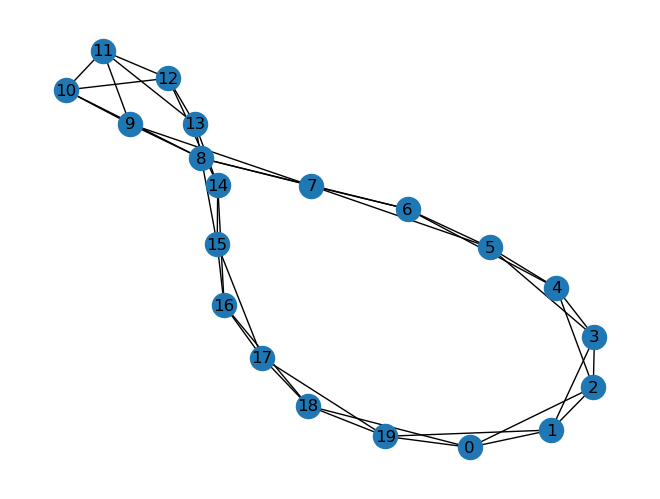

In [6]:
G = nx.circulant_graph(20, [1, 2])

nx.draw(G, with_labels=True)
plt.show()

In [7]:
population = Population(G)

In [8]:
circulant_2_sim = Simulation(population)

In [9]:
circulant_2_sim.run()

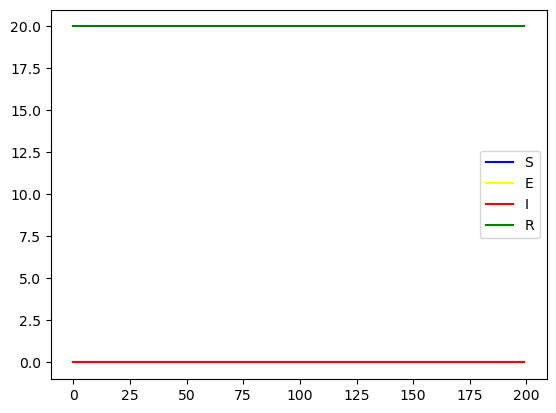

In [10]:
circulant_2_sim.plot()